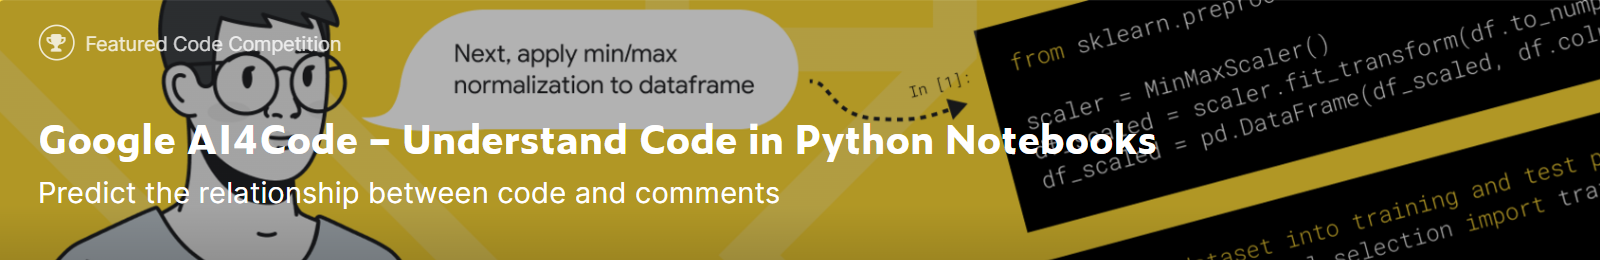

## Competition information:

### Objective: 
The goal of this competition is to understand the relationship between code and comments in Python notebooks. You are challenged to reconstruct the order of markdown cells in a given notebook based on the order of the code cells, demonstrating comprehension of which natural language references which code.

### Data Description
The dataset for this competition comprises about 160,000 Jupyter notebooks published by the Kaggle community. Jupyter notebooks are the tool of choice for many data scientists for their ability to tell a narrative with both code and natural language. These two types of discourse are contained within cells of the notebook, and we refer to these cells as either code cells or markdown cells (markdown being the text formatting language used by Jupyter).

Your task is to predict the correct ordering of the cells in a given notebook whose markdown cells have been shuffled.

The notebooks in this dataset have been selected and processed to ensure their suitability for the competition task. All notebooks:

Have been published publicly on Kaggle under the Apache 2.0 open source license.
Represent the most recently published version of the notebook.
Contain at least one code cell and at least one markdown cell.
Have code written in the Python language.
Have had empty cells removed.
This is a code competition, in which you will submit a model or code that will be run against a future test set:

The first-stage test set contains notebooks from an approximately 90-day historical window of time.
The second-stage test set will contain a similar number of notebooks, collected from a future 90-day window of time. This is necessary to prevent models from looking up the order of existing public notebooks. The selection criteria for second-stage notebooks will be monitored for competition fairness purposes. For example, it will exclude competition participants' own notebooks.

### Training Data
train/ - A folder comprising about 140,000 JSON files with the filenames corresponding to the id field in the csv files. Each file contains the code and markdown cells of a Kaggle notebook. The code cells are in their original (correct) order. The markdown cells have been shuffled and placed after the code cells.
>- train_orders.csv - Gives the correct order of the cells for each notebook in the train/ folder.
>>- id - The notebook in file {id}.json.
>>- cell_order - A space delimited list of the correct cell ordering given in terms of the order in {id}.json.
>- train_ancestors.csv - On Kaggle, a user may "fork" (that is, copy) the notebook of another user to create their own version. This file contains the forking history of notebooks in the training set. Note: There is no corresponding file for the test set.
>>- ancestor_id - Identifies sets of notebooks that have a common origin or "ancestor". As no notebook in the test set has an ancestor in the training set, you may find this field to be of use as a grouping factor when constructing validation splits.
>>- parent_id - Indicates that some version of the notebook id was forked from some version of the notebook parent_id. The notebook parent_id may or may not be present in the training data. (The parent may be missing because someone had forked a private notebook of their own, for instance.)

### Example Test Data
To help you author submission code, we include a few example instances selected from the test set. When you submit your notebook for scoring, this example data will be replaced by the actual test data, including the sample_submission.csv file.

test/ - A few example notebooks from the test set. The actual test set comprises about 20,000 notebooks in a format similar to the training set notebooks. No notebook in the test set has an ancestor in the training set.
sample_submission.csv - A sample submission file in the correct format. 


### Evaluation metric:
Predictions are evaluated by the Kendall tau correlation between predicted cell orders and ground truth cell orders accumulated across the entire collection of test set notebooks.

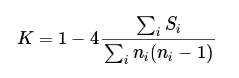

### Train notebook here: https://www.kaggle.com/code/arunamenon/ai4code-eda-modelling

## Import packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import json
from termcolor import colored
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)         # initiate notebook for offline plot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from tqdm import tqdm
from bisect import bisect
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import sys, os
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

SEED = 42

## Load data

In [ ]:
# train_orders = pd.read_csv('../input/AI4Code/train_orders.csv')
# train_ancestors = pd.read_csv('../input/AI4Code/train_ancestors.csv')
sample_submission = pd.read_csv('../input/AI4Code/sample_submission.csv')

## Modelling

References: https://www.kaggle.com/code/aerdem4/ai4code-pytorch-distilbert-baseline

In [ ]:
MAX_LEN = 512
BS = 8
NW = 8
EPOCHS = 4

In [ ]:
def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )

data_dir = Path('../input/AI4Code')

In [ ]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

In [ ]:
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.bert = AutoModel.from_pretrained("../input/bert-base-uncased-from-hg")
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [ ]:
class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained("../input/bert-base-uncased-from-hg")

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [ ]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

## Prediction

In [ ]:
model_chk = f"../input/bert-base-uncased-markdown-model/pytorch_best_model.bin"
model = MarkdownModel()
model.load_state_dict(torch.load(model_chk))
model = model.cuda()

In [ ]:
paths_test = list((data_dir / 'test').glob('*.json'))
notebooks_test = [
    read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
]
test_df = (
    pd.concat(notebooks_test)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
).reset_index()

In [ ]:
test_df["rank"] = test_df.groupby(["id", "cell_type"]).cumcount()
test_df["pred"] = test_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)

In [ ]:
test_df["pct_rank"] = 0
test_ds = MarkdownDataset(test_df[test_df["cell_type"] == "markdown"].reset_index(drop=True), max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

In [ ]:
_, y_test = validate(model, test_loader)

In [ ]:
test_df.loc[test_df["cell_type"] == "markdown", "pred"] = y_test

In [ ]:
sub_df = test_df.sort_values("pred").groupby("id")["cell_id"].apply(lambda x: " ".join(x)).reset_index()
sub_df.rename(columns={"cell_id": "cell_order"}, inplace=True)
sub_df.head()

In [ ]:
sub_df.to_csv("submission.csv", index=False)